In [5]:
import dropbot
import logging; logging.basicConfig(level=logging.DEBUG)
import time

import mr_box_peripheral_board as mrbox
import serial
import numpy as np

#Connect to dropbot
try:
    db_proxy.terminate()
except:
    pass

db_proxy = dropbot.SerialProxy()
print db_proxy.properties

#Connect to peripheral
reload(mrbox)

# Try to connect to MR-Box control board.
retry_count = 2
for i in xrange(retry_count):
    try:
        proxy.terminate()
    except NameError:
        pass
    try:
        proxy = mrbox.SerialProxy(port='COM12',baudrate=57600, settling_time_s=2.5)
        break
    except serial.SerialException:
        time.sleep(1)
else:
    raise IOError('Could not connect to MR-Box control board.')
    
proxy._timeout_s = 20

DEBUG:serial_device.threaded:Connection to port `COM11` closed
DEBUG:base_node_rpc.proxy:Connection lost `COM11`
DEBUG:base_node_rpc.proxy:Attempt to connect to device on port COM11 (baudrate=115200)
DEBUG:serial_device.threaded:Open `COM11` and monitor connection status
DEBUG:serial_device.threaded:connection_made: `COM11` `<ReaderThread(Thread-15, started daemon 10096)>`
DEBUG:base_node_rpc.proxy:Wait for connection to port COM11
INFO:base_node_rpc.proxy:Successfully connected to dropbot on port COM11
DEBUG:serial_device.threaded:Connection to port `COM12` closed
DEBUG:base_node_rpc.proxy:Attempt to connect to device on port COM12 (baudrate=57600)
DEBUG:base_node_rpc.proxy:Connection lost `COM12`
DEBUG:serial_device.threaded:Open `COM12` and monitor connection status
DEBUG:base_node_rpc.proxy:Wait for connection to port COM12


base_node_software_version                                         0.26
package_name                                                    dropbot
display_name                                                    DropBot
manufacturer                                              Sci-Bots Inc.
url                           http://gitlab.com/sci-bots/dropbot.py.git
software_version                                                   1.19
dtype: object


DEBUG:base_node_rpc.proxy:Attempt to connect to device on port COM12 (baudrate=57600)
DEBUG:serial_device.threaded:Open `COM12` and monitor connection status
DEBUG:serial_device.threaded:connection_made: `COM12` `<ReaderThread(Thread-18, started daemon 640)>`
DEBUG:base_node_rpc.proxy:Wait for connection to port COM12
INFO:base_node_rpc.proxy:Successfully connected to mr-box-peripheral-board on port COM12


In [6]:
# set output voltage to 3.3V
db_proxy.hv_output_selected = False

state = np.zeros(db_proxy.number_of_channels)
db_proxy.state_of_channels = state   
state

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.])

In [19]:
def set_RGB(color, intensity):    
    RGB_Channels = {'Red_Low':24, 'Red_Mid':28, 'Red_High':32, 
                    'Blue_Low':4, 'Blue_Mid':8, 'Blue_High':12, 
                    'Green_Low':44, 'Green_Mid':48, 'Green_High':52}
    
    rgb_c = color + '_'+ intensity
    state[RGB_Channels[rgb_c]] = 1
    db_proxy.state_of_channels = state 
    
def set_LED(led): # 0 to 12
    #LED0 is the top left LED
    LED_Channels = {'LED0':71, 'LED1':119,
               'LED2':79, 'LED3':75, 'LED4':115, 'LED5':111,
               'LED6':83, 'LED7':87, 'LED8':91, 'LED9':103, 'LED10':107,
               'LED11':95, 'LED12':99}
    
    led_c = 'LED'+str(led)
    state[LED_Channels[led_c]] = 1
    db_proxy.state_of_channels = state 

In [29]:
proxy.pin_mode(9, 1)
proxy.pmt_close_shutter()

Vcont = 700
pot_i = int((Vcont/1200.0)*255)
proxy.pmt_set_pot(pot_i)

0.63225806

In [30]:
from collections import OrderedDict
import pandas as pd

INPUT_RANGE_UNIPOLAR = 1
INPUT_RANGE_BIPOLAR = 2
CLOCK_SOURCE_EXTERNAL = 1
CLOCK_SOURCE_INTERNAL = 2
FORMAT_OFFSET = 1
FORMAT_TWOS_COMPLEMENT = 2
CONVERSION_MODE_SINGLE = 1
CONVERSION_MODE_CONTINUOUS = 2

def MAX11210_begin(proxy):
    proxy.MAX11210_setDefault();
    proxy.MAX11210_setLineFreq(60);  # 60 Hz
    proxy.MAX11210_setInputRange(INPUT_RANGE_UNIPOLAR);
    proxy.MAX11210_setClockSource(CLOCK_SOURCE_INTERNAL);
    proxy.MAX11210_setEnableRefBuf(True);
    proxy.MAX11210_setEnableSigBuf(True);
    proxy.MAX11210_setFormat(FORMAT_OFFSET);
    proxy.MAX11210_setConvMode(CONVERSION_MODE_SINGLE);
    proxy.MAX11210_selfCal();
    proxy.MAX11210_sysOffsetCal();
    proxy.MAX11210_sysGainCal();

MAX11210_begin(proxy)
calibration_settings = \
    pd.Series(OrderedDict([('SelfCalGain', proxy.MAX11210_getSelfCalGain()),
                           ('SelfCalOffset', proxy.MAX11210_getSelfCalOffset()),
                           ('SysGainCal', proxy.MAX11210_getSysGainCal()),
                           ('SysOffsetCal', proxy.MAX11210_getSysOffsetCal())]))
print '# Calibration settings #\n'
print calibration_settings

# Calibration settings #

SelfCalGain      12572689
SelfCalOffset    16777204
SysGainCal       16777215
SysOffsetCal       108410
dtype: int64


In [31]:
import time

color = ['Red', 'Blue', 'Green']
intensity = ['Low', 'Mid', 'High']
led = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

rate = 60
max_range = 100

proxy.MAX11210_setConvMode(1)
proxy.pmt_open_shutter()

bkg = []

#Measure Background
for i in range (0,max_range):
    proxy.MAX11210_setRate(rate)
    bkg_i = proxy.MAX11210_getData()
    bkg.append(bkg_i)
background = sum(bkg)/len(bkg)
background /= (((2 ** 24 - 1)/(3.0))*30e3)
print 'Background: %s' %background

dtype = [('Color','str'), ('Intensity','str'), ('Electrode','int32'), ('Signal','float32'),('X','float32'),('Y','float32')]
values = np.zeros(13*3*3, dtype=dtype)
df = pd.DataFrame(values)
enumerator = 0

x_pos=[3,4,2,3,4,5,1,2,3,4,5,3,4]
y_pos=[4,4,3,3,3,3,2.5,2,2,2,2,1,1]

R_x_pos = [2.75, 4.25, 1.75, 2.75, 4.25, 5.25, 0.75, 1.75, 2.75, 4.25, 5.25, 2.75, 4.25]
R_y_pos = [3.75, 3.75, 3.25, 3.25, 3.25, 3.25, 2.75, 1.75, 1.75, 1.75, 1.75, 1.25, 1.25]

B_x_pos = [2.75, 3.75, 2.25, 3.25, 4.25, 5.25, 1.25, 1.75, 2.75, 3.75, 4.75, 3.25, 4.25]
B_y_pos = [4.25, 3.75, 3.25, 3.25, 2.75, 2.75, 2.75, 2.25, 2.25, 1.75, 1.75, 1.25, 0.75]

G_x_pos = [3.25, 3.75, 2.25, 3.25, 3.75, 4.75, 1.25, 2.25, 3.25, 3.75, 4.75, 3.25, 3.75]
G_y_pos = [4.25, 4.25, 2.75, 2.75, 2.75, 2.75, 2.25, 2.25, 2.25, 2.25, 2.25, 0.75, 0.75]



for x in led:
    for y in color:
        for z in intensity:
            state = np.zeros(db_proxy.number_of_channels) #Turn off all channels
            db_proxy.state_of_channels = state
            time.sleep(0.1)
            #Read once to clear the ADC
            proxy.MAX11210_setRate(rate)
            proxy.MAX11210_getData()
            #Set the Color, the Intensity and the LED
            set_RGB(y, z)
            set_LED(x)
            readings = []
            for i in range (0,max_range):
                proxy.MAX11210_setRate(rate)
                reading_i = proxy.MAX11210_getData()
                readings.append(reading_i)
            signal = sum(readings)/len(readings)
            signal /= (((2 ** 24 - 1)/(3.0))*30e3)
            df.loc[enumerator, 'Color'] = y
            df.loc[enumerator, 'Intensity'] = z
            df.loc[enumerator, 'Electrode'] = x
            df.loc[enumerator, 'Signal'] = signal
            if (y == 'Red'):
                df.loc[enumerator, 'X'] = R_x_pos[x-1]
                df.loc[enumerator, 'Y'] = R_y_pos[x-1]
            elif (y == 'Blue'):
                df.loc[enumerator, 'X'] = B_x_pos[x-1]
                df.loc[enumerator, 'Y'] = B_y_pos[x-1]
            elif (y == 'Green'):
                df.loc[enumerator, 'X'] = G_x_pos[x-1]
                df.loc[enumerator, 'Y'] = G_y_pos[x-1]
            enumerator += 1
            #print 'Color: %s , Intensity: %s, Electrode: %s, Signal: %s' %(y , z, x, signal)

            
proxy.pmt_close_shutter()
state = np.zeros(db_proxy.number_of_channels) #Turn off all channels
db_proxy.state_of_channels = state 


Background: 4.17232538297e-11


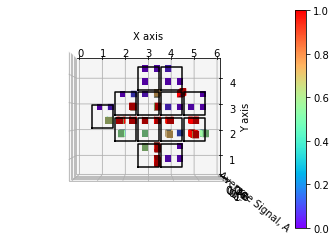

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D

df['Signal_N'] = 0

X_axis = df.loc[:,'X']  
Y_axis = df.loc[:,'Y']
df.loc[df['Color'] == 'Red', 'Signal_N'] = (df.loc[df['Color'] == 'Red', 'Signal']/ 
                                            df.loc[df['Color'] == 'Red', 'Signal'].max())
df.loc[df['Color'] == 'Blue', 'Signal_N'] = (df.loc[df['Color'] == 'Blue', 'Signal']/ 
                                            df.loc[df['Color'] == 'Blue', 'Signal'].max())
df.loc[df['Color'] == 'Green', 'Signal_N'] = (df.loc[df['Color'] == 'Green', 'Signal']/ 
                                            df.loc[df['Color'] == 'Green', 'Signal'].max())
Z_axis = df.loc[:,'Signal_N'] # Normalize Signal

dz = np.zeros_like(Z_axis)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
col= cm.rainbow(Z_axis)
ax.bar3d(X_axis, Y_axis, dz, 0.25, 0.25,Z_axis, color=col)
ax.set_xlim([0,6])
ax.set_xlim([0,6])
ax.view_init(90, -90)

sm = plt.cm.ScalarMappable(cmap=plt.get_cmap("rainbow"), norm=plt.Normalize(vmin=0, vmax=1))
# fake up the array of the scalar mappable. Urgh...
sm._A = []
plt.colorbar(sm)

ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Average Signal, A')

Xx=[]
Yy=[]
w = 0.45

for i in range(0,len(x_pos)):          
    Xx =[(x_pos[i]-w),(x_pos[i]-w),(x_pos[i]+w),(x_pos[i]+w),(x_pos[i]-w)]
    Yy =[(y_pos[i]-w),(y_pos[i]+w),(y_pos[i]+w),(y_pos[i]-w),(y_pos[i]-w)]
    plt.plot(Xx, Yy, color='0')
    Xx=[]
    Yy=[]

In [34]:
df.to_csv('PMT_Analysis.csv')

In [11]:
color = ['Red', 'Blue', 'Green']
intensity = ['Low', 'Mid', 'High']
led = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

for x in led:
    for y in color:
        for z in intensity:
            state = np.zeros(db_proxy.number_of_channels) #Turn off all channels
            db_proxy.state_of_channels = state
            time.sleep(0.1)
            #Set the Color, the Intensity and the LED
            set_RGB(y, z)
            set_LED(x)
            time.sleep(1)
state = np.zeros(db_proxy.number_of_channels) #Turn off all channels
db_proxy.state_of_channels = state

In [33]:
df

,Color,Intensity,Electrode,Signal,X,Y,Signal_N
0,Red,Low,0,2.980232e-11,4.25,1.25,7.587036e-07
1,Red,Mid,0,1.788139e-11,4.25,1.25,4.552222e-07
2,Red,High,0,5.960465e-12,4.25,1.25,1.517407e-07
3,Blue,Low,0,0.000000e+00,4.25,0.75,0.000000e+00
4,Blue,Mid,0,0.000000e+00,4.25,0.75,0.000000e+00
5,Blue,High,0,8.224488e-07,4.25,0.75,8.224488e-03
6,Green,Low,0,2.530039e-07,3.75,0.75,2.530039e-03
7,Green,Mid,0,6.796658e-07,3.75,0.75,6.796659e-03
8,Green,High,0,1.602167e-06,3.75,0.75,1.602167e-02
9,Red,Low,1,0.000000e+00,2.75,3.75,0.000000e+00
